In [1]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import importlib

sys.path.append('C:\\Users\\kpandit\\PICASSO\\picasso\\')
import mine
importlib.reload(mine)

<module 'mine' from 'C:\\Users\\kpandit\\PICASSO\\picasso\\mine.py'>

In [1]:
#from pytorch_msssim import SSIM, MS_SSIM
from torch.nn.functional import log_softmax

class PICASSOnn(nn.Module):
    def __init__(self, n_source=1, n_sink=1, encoder=None, decoder=None, T = None, px_bit_depth=12, label_depth=6, beta=1):

        super().__init__()
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        self.bit_depth = px_bit_depth
        self.max_px = 2**px_bit_depth-1
        self.n_source = n_source
        self.n_sink = n_sink
        self.label_depth = label_depth

        
        if encoder is None:
            self.encoder = nn.Sequential(
                nn.Linear(1, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256,1),
                nn.Hardtanh(min_val=0.0, max_val=1.0)
            )
        else:
            self.encoder = encoder
        self.encoder.to(self.device)

        
        if decoder is None:
            self.decoder = nn.Sequential(
                nn.Linear(1, 1, bias=False),
                nn.Hardtanh(min_val=0.0, max_val=4095.0)
            )
        else:
            self.decoder = decoder
        self.decoder.to(self.device)
        
#         if T is None:
#             self.T = nn.Sequential(
#                 nn.Linear(2, 256),
#                 nn.ReLU(),
#                 nn.Linear(256, 256),
#                 nn.ReLU(),
#                 nn.Linear(256, 1),
#                 nn.Softmax(dim=0)
#             ) 
#         else:
#             self.T = T
#         self.T.to(self.device)
        
        self.sigmoid = nn.Sigmoid()
        
        #self.contrast_loss = ContrastLoss()
        self.l1_loss = nn.L1Loss()
        self.ce_loss2 = nn.CrossEntropyLoss()
        #self.ssim_loss = SSIM(win_size = 7, data_range = 4095, channel=1)
        self.mi_loss = mine.MINE()
        self.mi_weight = beta
        self.contrast_weight = 10
        self.alpha = torch.tensor([1.0], requires_grad=True, device=self.device)
        self.background = torch.tensor(0.0, requires_grad=True, device=self.device)
        self.constraints = weightConstraint()
        self.tanh = nn.Hardtanh(min_val=0.0, max_val=1.0)
        
        self.label_filter = nn.Hardtanh(min_val=0.1, max_val=self.bit_depth)
        self.max_label = 1
        self.bg_px = self.max_px
        self.initial_iter = True
        
        
    def label_data(self, source, sink):
        min_px = torch.min(source)
        
        if self.initial_iter:
            if min_px < self.bg_px:
                self.bg_px = min_px
            
        source_ = source/self.bg_px
        labels = torch.round(torch.log2(sink/source/source_*2))
        labels[labels < 0] = 0
#         labels = torch.round(torch.log2(label_filter(sink/source)))
#         labels[labels < 1] = 1
#         self.max_label = torch.max(labels)
        #labels = labels/self.max_label
        #labels = label_filter(torch.log2((sink-source)/source+1)-1)/self.bit_depth
        #labels[labels < 1] = 0
        #labels = labels-1
        #labels[labels == 2] = 1
        
        return labels
    
    def label_nospill(self, source, no_spill):
        
        
        #labels = torch.log2(self.label_filter(no_spill/(source+1/self.max_px)*2))
        labels = torch.log2(self.label_filter(no_spill/(source+1/self.max_px)*2))
        #labels = labels/self.max_label

        
        return labels
    
    def contrast_loss(self, x, y):
        k2 = 0.03
        c2 = (1*k2)**2
        varx = torch.var(x)
        vary = torch.var(y)
        score = (2*varx**0.5*vary**0.5+c2)/(varx+vary+c2)
        
        score = 1-score #keep contrast similiar
        
        return score
        
    def forward(self, xy):
        
        xy = xy/self.max_px
        #xy = xy.float()
        source, sink = xy.chunk(2,dim=-1)
        labels = self.label_data(source, sink).detach()
        
        
        
        #labels = torch.round(source*self.label_depth).long().squeeze()
        
#         if self.mi_weight is None:
#             self.mi_weight = -1/torch.sum(torch.softmax(source,dim=0)*log_softmax(source,dim=0))
#             print('MI Weight=',self.mi_weight)
        # Calculate max mutual information of batch
#         hist = source.histc(bins = 4095, min=0, max=1)
#         npx = hist.sum(dim=0)
#         hist = hist/npx
#         hist = hist[hist>0]
#         hist.sum(dim=0)
#         max_mi = -torch.sum(hist*torch.log(hist)) # entropy of source
#         if max_mi > 1:
#             max_mi = 1/max_mi
        
        
        # Calculate initial guess  = sink-source
        #initial_guess = self.decoder(sink-source)
        encoded = self.encoder(source)
        #encoded = self.alpha*source
        
        
        
        #encoded = self.encoder(xy)
        
        #source_, sink_ = encoded.chunk(2, dim=1)
        decoded = self.decoder(encoded)
        
        
        
        #ce_loss1 = self.ce_loss1(decoded, target=labels)*0
        
        
#         mi_loss = self.mi_loss.forward(torch.cat([source, decoded],1))
# #         if mi_loss > max_mi:
# #             mi_loss = 0/max_mi
        
#         loss = ssim_loss - mi_loss
        
        #no_spill = self.tanh(sink-encoded)
        no_spill = sink-encoded
        no_spill_labels = self.label_nospill(encoded, no_spill)
        
        l1_loss = self.l1_loss(labels.float(), no_spill_labels.float())*0
        
        contrast_loss = self.contrast_loss(sink, no_spill)
        
        #no_spill = sink-encoded
        xy_ = torch.stack([source.flatten(), no_spill.flatten()],1)
        mi_loss = (1-self.mi_loss.forward(xy_))*self.mi_weight
        #mi_loss = torch.tensor(0.0)
        #ssim_loss = 0*self.ssim(source, no_spill)
        decoded2 = self.decoder(no_spill)
        #ce_loss2 = self.ce_loss2(decoded2, target=labels)*0
        ce_loss2 = 0
        #mi_loss = -self.ssim(source, encoded)
        
        # adaptive gradient clipping
        #scale = torch.stack([mi_loss, ce_loss1]).abs().min()/mi_loss.abs()
#         if mi_loss.abs() > contrast_loss.abs():
#             scale = contrast_loss/mi_loss
#             mi_loss = mi_loss*scale.abs()
#         else:
#             scale = mi_loss/contrast_loss
#             contrast_loss = contrast_loss*scale.abs()
        #contrast_loss = contrast_loss - 1
        
        
        loss = mi_loss + l1_loss + ce_loss2 + contrast_loss # + ssim_loss
        
        return encoded, loss, mi_loss, contrast_loss
    
    def ssim(self, X,Y):

        px_size = int(X.size()[0]**0.5)
        
        # Reshape to 2D image and add channel and batch dimension
        X = X.reshape(px_size, px_size).unsqueeze(dim=0).unsqueeze(dim=0)
        Y = Y.reshape(px_size, px_size).unsqueeze(dim=0).unsqueeze(dim=0)
        #X = X.unsqueeze(dim=0).unsqueeze(dim=0)
        #Y = Y.unsqueeze(dim=0).unsqueeze(dim=0)
        
        #print(X.size())
        
        #loss = 1-self.ssim_loss(X,Y) # make images more similiar
        loss = self.ssim_loss(X,Y) # make images less similiar
        
        return loss
    
    
    def train_loop(self, dataset, max_iter=100, batch_size=1, lr=1e-4, opt=None):

        old_param = self.flatten_parameters()
       
        mine_params = []
        transform_params = []
        
#         transform_weight = []
#         transform_bias = []
#         for name, param in self.named_parameters():
#             if 'encoder' in name and 'weight' in name:
#                 transform_weight.append(param)
#             elif 'encoder' in name and 'bias' in name:
#                 transform_bias.append(param)
#             elif 'mi_loss' in name:
#                 mine_params.append(param)

        for name, param in self.named_parameters():
            if 'encoder' in name:
                transform_params.append(param)
            elif 'mi_loss' in name:
                mine_params.append(param)
                
        if opt is None:
#             opt = torch.optim.Adam([{'params':mine_params},
#                                     {'params':transform_bias}, 
#                                     {'params':transform_weight}], lr=lr)

            opt = torch.optim.Adam([{'params':mine_params}, {'params':transform_params}], lr=lr)
            opt.param_groups[0]['lr'] = 1e-5
            #opt.param_groups[1]['lr'] = 1e-2
         
        loss_ = []
        for i in range(1, max_iter + 1):
            parameters = []
            batch_loss = 0; batch_mi_loss = 0; batch_bottleneck_gain = 0
            for batch, xy in enumerate(DataLoader(dataset, batch_size, shuffle=True)):
                xy = xy.squeeze(0)
                opt.zero_grad()
                decoded, loss, mi_loss, bottleneck_gain  = self.forward(xy)
                batch_loss += loss.item()
                batch_mi_loss += mi_loss.item()
                batch_bottleneck_gain += bottleneck_gain.item()
#                 batch_loss = loss.item()
#                 batch_mi_loss = mi_loss.item()
#                 batch_bottleneck_gain = bottleneck_gain.item()
                #loss_.append([batch_loss, mi_loss.detach().cpu(), bottleneck_gain.detach().cpu()])
                loss.backward()
                opt.step()
            
                self._modules['encoder'].apply(self.constraints)
                if self._modules['encoder'][0].bias is None:
                    bias = 0
                else:
                    try:
                        bias = self._modules['encoder'][0].bias.item()
                    except:
                        bias = 0
                try:
                    alpha = self._modules['encoder'][0].weight.item()
                except:
                    alpha = 0
                parameters.append([alpha, bias])
            #print(self.background)

            loss_.append([batch_loss, batch_mi_loss, batch_bottleneck_gain])

            new_param = self.flatten_parameters()
            param_norm = torch.linalg.norm(new_param - old_param)
            old_param = new_param

            if i % (max_iter // 4) == 0:
                print(f"It {i} - loss: {loss_[-1][0]/batch}")

#             if param_norm.item() < 0.05:
#                 print(f"Converged in {i} iterations")
#                 break

            if self.initial_iter:
                self.initial_iter = False
                
        #decoded = decoded * self.max_px
        loss_ = np.array(loss_)/batch
        loss_ = np.array(loss_)
            
        return decoded, loss_, parameters
    
    def test(self, dataset, batch_size=1):
        
        pred = np.array([], dtype='int16')
        batch_loss = 0; batch_mi_loss = 0; batch_bottleneck_gain = 0
        for batch, xy in enumerate(DataLoader(dataset, batch_size)):
            xy = xy.squeeze(dim=0)
            decoded, loss, mi_loss, bottleneck_gain  = self.forward(xy)
            
            #print(batch, loss.item(), mi_loss.item(), bottleneck_gain.item())
            batch_loss += loss.item()
            batch_mi_loss += mi_loss.item()
            batch_bottleneck_gain += bottleneck_gain.item()
            
            
            decoded = decoded*self.max_px
            #batch_pred = np.array(decoded.detach().cpu(),dtype='int16').squeeze()
            batch_pred = np.array(decoded.detach().cpu()).squeeze()
            
            pred = np.concatenate([pred,batch_pred])
            
        
        return pred 
        

    def flatten_parameters(self):

        p = torch.tensor([],device=self.device)

        for param in self.parameters():
             p = torch.cat([p, param.data.flatten()])

        return p
    
 
# class ContrastLoss(torch.autograd.Function):
#     def __init__(self): 
#         self.k2 = 0.03
#         self.max_px = 1
#         #super(ContrastLoss, self).__init__():
    
#     @staticmethod
#     def forward(ctx, X, Y):
        
#         c2 = (self.max_px*k2)**2
        
#         varx = torch.var(X)
#         vary = torch.var(Y)
#         score = (2*varx**0.5*vary**0.5+c2)/(varx+vary+c2)
        
#         score = 1-score #keep contrast similiar
        
#         return score
    
class initializeWeight(object):
    def __init__(self):
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            #print("Entered weight")
            w=module.weight.data
            w.fill_(1.0)
            #w=w.clamp(0.01,2.0)
            module.weight.data=w
        if hasattr(module,'bias'):
            b=module.bias
            if b is not None:
                #print("Entered bias")
                b=module.bias.data
                b.fill_(-0.01)
                #b=b.clamp(-0.05,0.05)
                module.bias.data=b
    
class weightConstraint(object):
    def __init__(self):
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            #print("Entered weight")
            w=module.weight.data
            #w.fill_(1.0)
            w=w.clamp(0.01,2.0)
            module.weight.data=w
        if hasattr(module,'bias'):
            b=module.bias
            if b is not None:
                #print("Entered bias")
                b=module.bias.data
                #b.fill_(0.0)
                b=b.clamp(-0.10,0.0)
                module.bias.data=b

NameError: name 'nn' is not defined

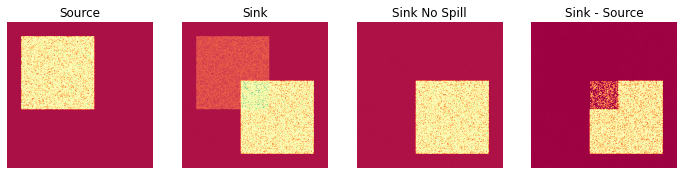

torch.Size([65536, 2])

In [5]:
import matplotlib.pyplot as plt

px_size = 256
mixing_parameter = 0.25
bit_depth = 12
signal_min = 1000

max_px = 2**bit_depth-1
# Source fluorescence
source_bg = torch.randint(low=90, high=120, size=(px_size,px_size), dtype=torch.int16)  # background
#source_signal = torch.randint(low=signal_min, high=max_px, size=(px_size,px_size), dtype=torch.int16)
px_i = int(px_size/2)
px_i_ = int(px_i/5)
source_signal = torch.zeros_like(source_bg)
ind = px_i + px_i_
source_signal[px_i_:ind,px_i_:ind] = torch.randint(low=500, high=3000, size=(px_i,px_i), dtype=torch.int16)
source = source_bg+source_signal
# Sink fluorescence
sink_bg = torch.randint(low=100, high=135, size=(px_size,px_size), dtype=torch.int16)  # background
sink_signal = torch.zeros_like(source_bg)
ind = px_size-px_i-px_i_
ind_ = px_size-px_i_
sink_signal[ind:ind_,ind:ind_] = torch.randint(low=500, high=3000, size=(px_i,px_i), dtype=torch.int16)
# Spillover fluorecence
spill = mixing_parameter*source_signal       # spillover
spill = spill.type(torch.int16)
sink_ = sink_bg+sink_signal+spill
sink_ = sink_.clamp(max=4095)
# Clean sink channel
sink_clean = sink_bg+sink_signal


fig, axs = plt.subplots(1,4, figsize = (12,3))
axs[0].imshow(source, cmap='Spectral', vmin=0, vmax=4095)
axs[0].set_title('Source')
axs[0].axis('off')
axs[1].imshow(sink_, cmap='Spectral', vmin=0, vmax=4095)
axs[1].set_title('Sink')
axs[1].axis('off')
axs[2].imshow(sink_clean, cmap='Spectral', vmin=0, vmax=4095)
axs[2].set_title('Sink No Spill')
axs[2].axis('off')
axs[3].imshow(sink_-source, cmap='Spectral', vmin=0, vmax=4095)
axs[3].set_title('Sink - Source')
axs[3].axis('off')
            
plt.show()

source = source.flatten()
#source = source.flatten().long()
#source = source.unsqueeze(dim=0)
sink = sink_.flatten()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
source = source.to(device)
sink = sink.to(device)
dataset = torch.stack([source, sink],1)
dataset.size()

Chunk data and create dataset

torch.Size([64, 32, 32, 2])
torch.Size([1024, 2])


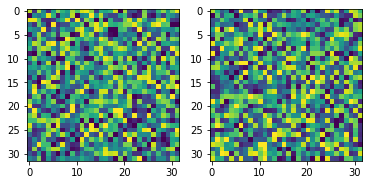

In [601]:
tilepx = 32
nsplits = int(px_size/tilepx) # 8
ntiles = nsplits**2 #64

source_ = source.reshape(nsplits,tilepx,nsplits,tilepx).swapaxes(1,2).reshape((ntiles,tilepx,tilepx))
sink_ = sink.reshape(nsplits,tilepx,nsplits,tilepx).swapaxes(1,2).reshape((ntiles,tilepx,tilepx))

dataset = torch.stack([source_, sink_],-1)
print(dataset.size())

fig, axs = plt.subplots(1,2, figsize = (6,3))
axs[0].imshow(dataset[0,:,:,0].cpu())
axs[1].imshow(dataset[0,:,:,1].cpu())

so = source_[0].squeeze(0).flatten()
si = sink_[0].squeeze(0).flatten()
s = torch.stack([so,si],1)
print(s.size())

In [558]:
from pytorch_msssim import ssim

im1 = source.reshape(px_size,px_size).unsqueeze(dim=0).unsqueeze(dim=0).float()
im2 = sink.reshape(px_size,px_size).unsqueeze(dim=0).unsqueeze(dim=0).float()
im3 = sink_bg+sink_signal
im3 = im3.reshape(px_size,px_size).unsqueeze(dim=0).unsqueeze(dim=0).float().to('cuda')
ssim_12 = ssim(im1, im2, data_range=4095)
ssim_13 = ssim(im1, im3, data_range=4095)
ssim_23 = ssim(im2, im3, data_range=4095)
print('source v sink+spill', ssim_12)
print('source v sink', ssim_13)
print('sink+spill v sink', ssim_23)

source v sink+spill tensor(0.6312, device='cuda:0')
source v sink tensor(0.4437, device='cuda:0')
sink+spill v sink tensor(0.7510, device='cuda:0')


In [120]:
hist = source.histc(bins = 4095, min=0, max=4096)
npx = hist.sum(dim=0)
hist = hist/npx
hist = hist[hist>0]
hist.sum(dim=0)
h = -1/torch.sum(hist*torch.log(hist))



tensor(0.2668, device='cuda:0')

Label pixels in sink channel

tensor(5.1081, device='cuda:0')
12
N labels: tensor(6., device='cuda:0')


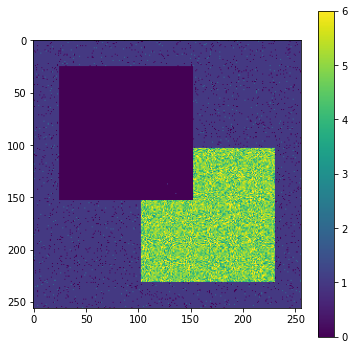

In [559]:
# label_depth = torch.round(torch.max(torch.log2(sink/source+1))).long()
# label_filter = nn.Hardtanh(min_val=0.0, max_val=4096)
# labels = torch.round(torch.log2(label_filter(sink/source)))
# labels[labels < 1] = 1

print(torch.max(torch.log2(sink/source)))

min_px = torch.min(source)
source_ = source/min_px
labels = torch.round(torch.log2(sink/source/source_*2))
labels[labels < 0] = 0
#labels = labels/24
#labels = labels-1
labels[labels < 0] = 0
#labels[labels == 1] = 0
#labels = labels/24

# label_filter = nn.Hardtanh(min_val=1.0, max_val=12.0)
# labels = torch.round(label_filter(sink/source)).long().squeeze()-1

print(label_depth)
fig, axs = plt.subplots(1,1, figsize = (6,6))
im = axs.imshow(labels.cpu().reshape(px_size,px_size))
plt.colorbar(im, ax=axs)
print('N labels:', torch.max(labels))

In [232]:
og_picasso._modules['encoder'][0].weight

Parameter containing:
tensor([[-0.2101]], device='cuda:0', requires_grad=True)

In [578]:
# Create model
label_depth = 12
#sink_minpx = sink.min()/4095
encoder = nn.Sequential(
                nn.Linear(1, 1, bias=False),
                nn.Hardtanh(min_val=0, max_val=1.0)
                #nn.Sigmoid()
            )

#decoder = nn.Identity()
source_maxpx = source.max()/4095
source_minpx = source.min()/4095
#decoder= nn.Hardtanh(min_val=source_minpx, max_val=source_maxpx)
#decoder = nn.Tanh()


decoder = nn.Sequential(
                #nn.Hardtanh(min_val=0.0, max_val=1.0),
                nn.Linear(1, 6, bias=False),  
            )
og_picasso = PICASSOnn(encoder=encoder, decoder=decoder, beta = 1.0)
#og_picasso.contrast_weight = 1000

# limit weights to between 0 and 1
init_weights= initializeWeight()
og_picasso._modules['encoder'].apply(init_weights)

# Train
decoded, loss, parameters = og_picasso.train_loop(dataset, batch_size = 1024, max_iter=10, lr=1e-2)

Using cuda
It 2 - loss: 0.0012534894640483553
It 4 - loss: 9.759834834507533e-05
It 6 - loss: 6.026502639528305e-05
It 8 - loss: 4.947374737451947e-05
It 10 - loss: 4.818515172080388e-05


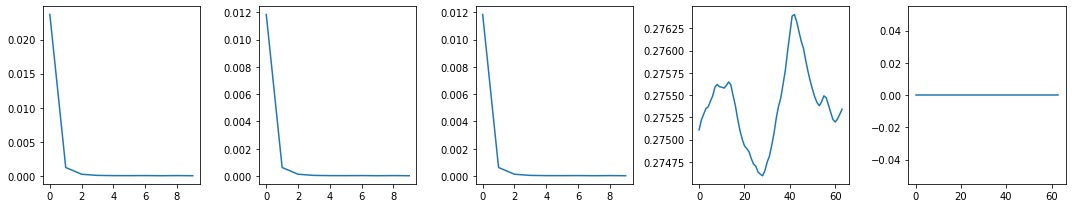

In [579]:
# Plot loss

import numpy as np

parameters = np.array(parameters)

fig, ax = plt.subplots(1,5, figsize = (15,3))
ax[0].plot(loss[:,0])
ax[1].plot(loss[:,1])
ax[2].plot(loss[:,2])
ax[3].plot(parameters[:,0])
ax[4].plot(parameters[:,1])


fig.tight_layout()

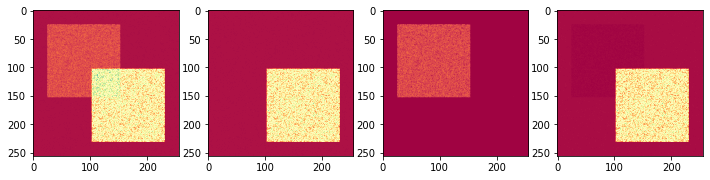

In [580]:
pred = og_picasso.test(dataset, batch_size=1024)
pred = pred.reshape(px_size, px_size)
fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].imshow(sink_, cmap='Spectral', vmin=0, vmax=4095)
ax[1].imshow(sink_clean, cmap='Spectral', vmin=0, vmax=4095)
ax[2].imshow(pred, cmap='Spectral', vmin=0, vmax=4095)
ax[3].imshow(sink_-pred, cmap='Spectral', vmin=0, vmax=4095)

Add bias to original picasso

In [45]:
# Create model
sink_minpx = sink.min()/4095
encoder = nn.Sequential(
                nn.Linear(1, 1, bias=True),
                nn.Hardtanh(min_val=0, max_val=1.0)
                #nn.Sigmoid()
            )
source_maxpx = source.max()/4095
source_minpx = source.min()/4095
#decoder= nn.Hardtanh(min_val=source_minpx, max_val=source_maxpx)
# decoder = nn.Sequential(
#                 nn.Hardtanh(min_val=0.0, max_val=1.0),
#                 nn.Linear(1, label_depth, bias = False),  
#             )
picasso_bias = PICASSOnn(encoder=encoder, beta = 0.0)
                         
# limit weights to between 0 and 1
init_weights = initializeWeight()
picasso_bias._modules['encoder'].apply(init_weights)

# Train
decoded, loss_bias, parameters = picasso_bias.train_loop(dataset,batch_size=1024, max_iter=25, lr=1e-3)

Using cuda
It 6 - loss: 0.008682686185079908
It 12 - loss: 0.0001970567400493319
It 18 - loss: 0.00011328950760856508
It 24 - loss: 7.574236582195948e-05


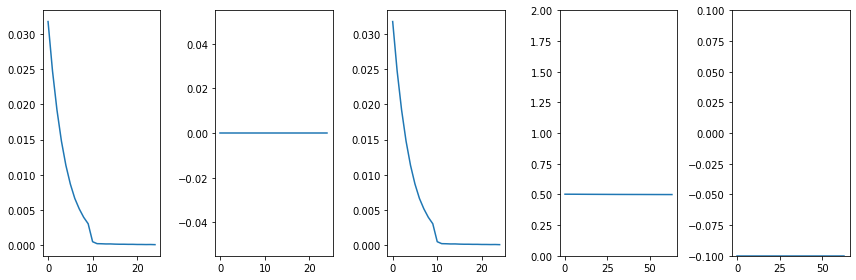

In [49]:
# Plot loss

import numpy as np

parameters = np.array(parameters)

fig, ax = plt.subplots(1,5, figsize = (12,4))
ax[0].plot(loss_bias[:,0])
# ax[0].set_xlabel('iteration')
# ax[0].set_ylabel('loss')

#ax[0].set_ylim(0, 1)
ax[1].plot(loss_bias[:,1])
#ax[0].set_xlabel('iteration')

ax[2].plot(loss_bias[:,2])

ax[3].plot(parameters[:,0])
ax[3].set_ylim(0,2)
ax[4].plot(parameters[:,1])
ax[4].set_ylim(-0.1,0.1)


fig.tight_layout()
#plt.savefig('bias_MINE_loss.png', dpi=300)

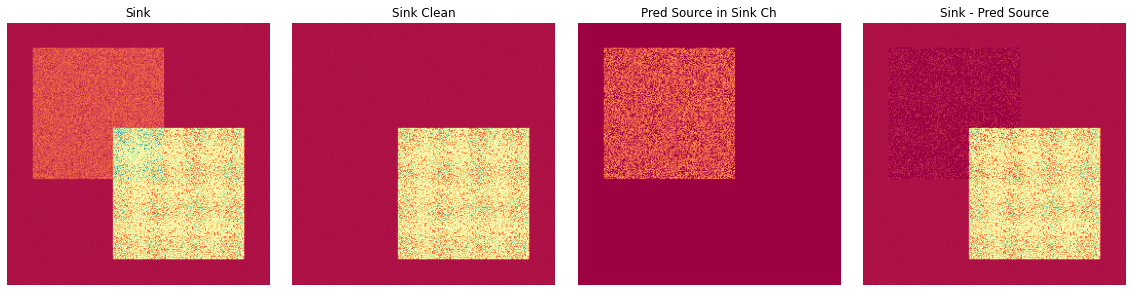

In [47]:
pred = picasso_bias.test(dataset, batch_size=1024)
pred = pred.reshape(px_size, px_size)
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(sink_, cmap='Spectral', vmin=0, vmax=4095)
ax[0].set_title('Sink')
ax[0].axis('off')

ax[1].imshow(sink_clean, cmap='Spectral', vmin=0, vmax=4095)
#ax[1].imshow(sink_clean, cmap='Spectral')
ax[1].set_title('Sink Clean')
ax[1].axis('off')

ax[2].imshow(pred, cmap='Spectral', vmin=0, vmax=4095)
ax[2].set_title('Pred Source in Sink Ch')
ax[2].axis('off')

ax[3].imshow(sink_-pred, cmap='Spectral', vmin=0, vmax=4095)
#ax[3].imshow(sink_-pred, cmap='Spectral')
ax[3].set_title('Sink - Pred Source')
ax[3].axis('off')
fig.tight_layout()

#plt.savefig('bias_MINE_imresults.png', dpi=300)

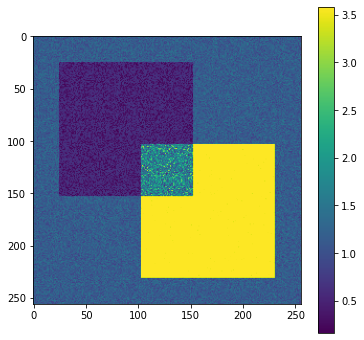

In [344]:
no_spill_ = sink_-pred
labels = picasso_bias.label_nospill(source, no_spill_.flatten().cuda())

# labels = torch.log2(no_spill_.flatten().cuda()/source+1)*2
# min_labels = torch.min(labels)
# print(min_labels)
# labels[labels == 1] = 0
# labels = labels - min_labels
# labels[labels > 12] = 12

fig, axs = plt.subplots(1,1, figsize = (6,6))
im = axs.imshow(labels.cpu().reshape(px_size, px_size))
plt.colorbar(im, ax=axs)

Use a neural network to encode/decode the source channel

In [523]:
# Create model
sink_maxpx = sink.max()/4095
encoder = nn.Sequential(
                nn.Linear(1, 8, bias=True),
                #nn.ReLU(),
                #nn.Linear(8, 8, bias=True),
                #nn.ReLU(),
                nn.Linear(8,1, bias=True),
                nn.Hardtanh(min_val=0.0, max_val=1.0)
                #nn.Sigmoid()
            )

source_maxpx = source.max()/4095
source_minpx = source.min()/4095
#decoder= nn.Hardtanh(min_val=source_minpx, max_val=source_maxpx)
decoder = nn.Sequential(
                nn.Hardtanh(min_val=0.0, max_val=1.0),
                nn.Linear(1, label_depth),  
            )
picasso_nn = PICASSOnn(encoder = encoder, decoder = decoder, beta=1.0)

# initialize weights to 0.5 and bias to 0
init_weights= initializeWeight()
picasso_nn._modules['encoder'].apply(init_weights)

# Train
pred, loss_nn, parameters = picasso_nn.train_loop(dataset, batch_size = int(32**2), lr = 1e-2, max_iter = 25)

Using cuda
It 6 - loss: 0.004816558625962999
It 12 - loss: 0.004757979559519935
It 18 - loss: 0.004750768343607585
It 24 - loss: 0.0047224173470148964


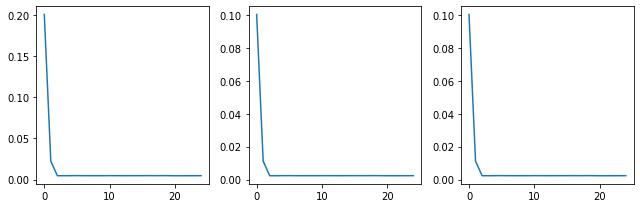

In [524]:
fig, ax = plt.subplots(1,3, figsize = (9,3))
ax[0].plot(loss_nn[:,0])
ax[1].plot(loss_nn[:,1])
ax[2].plot(loss_nn[:,2])

fig.tight_layout()

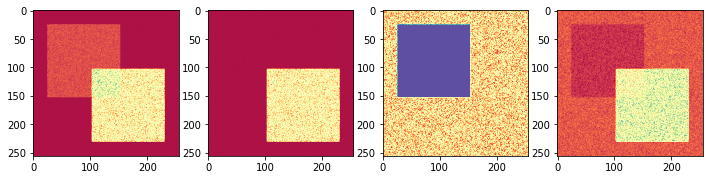

In [526]:
pred = picasso_nn.test(dataset, batch_size=int(128**2))
pred = pred.reshape(px_size, px_size)

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].imshow(sink_, cmap='Spectral', vmin=0, vmax=4095)
ax[1].imshow(sink_clean, cmap='Spectral', vmin=0, vmax=4095)
#ax[2].imshow(pred, cmap='Spectral', vmin=0, vmax=4095)
ax[2].imshow(pred, cmap='Spectral')
#ax[3].imshow(sink_-pred, cmap='Spectral', vmin=0, vmax=4095)
#ax[3].imshow(sink_-pred, cmap='Spectral')

In [884]:
pred

array([[1858.7726, 1864.3016, 1861.128 , ..., 1590.6991, 1595.491 ,
        1593.2935],
       [1864.5712, 1865.2377, 1859.4323, ..., 1593.724 , 1591.1226,
        1595.9606],
       [1857.0554, 1857.4023, 1863.9607, ..., 1592.9337, 1594.5143,
        1597.9213],
       ...,
       [1594.3986, 1595.2404, 1593.3257, ..., 2334.4373, 2337.1257,
        2331.1572],
       [1598.4615, 1593.8975, 1598.1077, ..., 2334.3179, 2337.3577,
        2337.7153],
       [1591.0905, 1595.099 , 1590.7244, ..., 2338.4434, 2332.4893,
        2332.7014]], dtype=float32)

In [115]:
# Create model
picasso_nn = PICASSOnn(beta=0)

# Train
decoded, loss_nn = picasso_nn.train_loop(source, sink, max_iter=100)

Using cuda
Using cuda
It 25 - loss: -0.0017067299771854896
Converged in 46 iterations


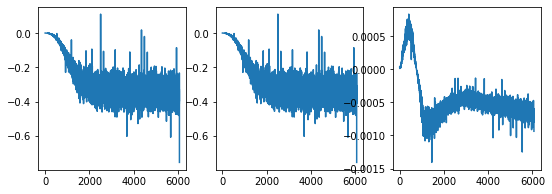

In [116]:
fig, ax = plt.subplots(1,3, figsize = (9,3))
ax[0].plot(loss_nn[:,0])
ax[1].plot(loss_nn[:,1])
ax[2].plot(loss_nn[:,2])

histogrammdd implemented in pytorch from https://github.com/miranov25/RootInteractive

In [443]:
class PICASSO_mine(nn.Module):
    def __init__(self, n_source=1, n_sink=1, encoder=None, T = None, px_bit_depth=12):

        super().__init__()
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        self.max_px = 2**px_bit_depth-1
        self.n_source = n_source
        self.n_sink = n_sink
        
        if encoder is None:
            encoder = nn.Sequential(
                nn.Linear(1, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256,1),
                nn.Hardtanh(min_val=0.0, max_val=1.0)
            )
        self.encoder = encoder
        self.encoder.to(self.device)
        
        self.decoder = nn.Sequential(
                nn.Linear(1,self.max_px)
        )
        self.decoder.to(self.device)

        if T is None:
            T = nn.Sequential(
                nn.Linear(2, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.LogSoftmax(dim=0)
            ) 

        self.T1 = T
        self.T2 = T
        self.T1.to(self.device)
        self.T2.to(self.device)
        
        self.loss_fn = nn.L1Loss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.mi_max = mine.MINE()
        
        
    def forward(self, xy):
        
        #xy = xy/self.max_px
        source, sink = xy.chunk(2,dim=1)
        
        spill_estimate = self.encoder(source)

        # minimize cross entropy loss between spill_estimate and source
        px_val_prob = self.decoder(spill_estimate)
        ce_loss = self.ce_loss(px_val_prob, source.long().squeeze())
#        xy = torch.cat([source, encoded],1)
#         t1 = self.T1(xy)
#         ymarg = xy[torch.randperm(xy.shape[0]),1]   # estimate marginal by shuffling along batch axis
#         xymarg = torch.stack([xy[:,0],ymarg],1)
#         t1_marg = self.T1(xymarg)
#         loss_xy = self.loss_fn(t1, t1_marg)
#          z = sink-spill_estimate
#         mse_loss = self.loss_fn(source, z)
#        mse_loss = torch.tensor(0, device=self.device)
        
        # maximize mutual information between encoded and sink
#         zy = torch.cat([sink, encoded],1)
#         t2 = self.T2(zy)
#         zymarg = torch.stack([zy[:,0],ymarg],1)
#         t2_marg = self.T2(zymarg)
        
        #loss = self.loss_fn(t1, t1_marg)
        #loss = self.loss_fn(t1, t1_marg) - self.loss_fn(t2, t2_marg)
        #loss = self.mi_max.forward(zy/self.max_px)
        
        # maximize mutual information between encoded and source
        #no_spill = self.decoder(torch.cat([source, sink-spill_estimate],1))
        no_spill = sink-spill_estimate
        
        xz = torch.cat([sink,no_spill],1)/self.max_px
        mi_loss = self.mi_max.forward(xz)
#         loss = loss_xy + loss_xz
#         mi_loss = torch.tensor(0, device=self.device)
    
        loss = ce_loss + mi_loss
        
        return no_spill, loss, ce_loss, mi_loss
    
    def train_loop(self, source, sink, max_iter=100, batch_size=500, opt=None):

        old_param = self.flatten_parameters()

        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=1e-4)
         
        loss_ = []
        for i in range(1, max_iter + 1):
            batch_loss = 0; batch_loss_xy = 0; batch_loss_zy = 0
            for batch, xy in enumerate(DataLoader(torch.stack([source, sink],1), 
                                                  batch_size, 
                                                  shuffle=True)):
                opt.zero_grad()
                no_spill, loss, loss_xy, loss_zy  = self.forward(xy)
                batch_loss += loss.item()
                batch_loss_xy += loss_xy.item()
                batch_loss_zy += loss_zy.item()
                loss.backward()
                opt.step()

            loss_.append([batch_loss/batch, batch_loss_xy/batch, batch_loss_zy/batch])

            new_param = self.flatten_parameters()
            param_norm = torch.linalg.norm(new_param - old_param)
            old_param = new_param

            if i % (max_iter // 4) == 0:
                print(f"It {i} - loss: {loss_[-1][0]/batch}")

#             if param_norm.item() < 0.05:
#                 print(f"Converged in {i} iterations")
#                 break
                
        loss_ = np.array(loss_)
            
        return no_spill, loss_
    
    def test(self, source, sink, batch_size=500):
        
        pred = np.array([], dtype='int16')
        for batch, xy in enumerate(DataLoader(torch.stack([source, sink],1), batch_size)):
            encoded, loss, loss_xy, loss_zy  = self.forward(xy)
            batch_pred = np.array(encoded.detach().cpu()).squeeze()
            pred = np.concatenate([pred,batch_pred])
        
        return pred 
        

    def flatten_parameters(self):

        p = torch.tensor([],device=self.device)

        for param in self.parameters():
             p = torch.cat([p, param.data.flatten()])

        return p

In [450]:
# Create model
encoder = nn.Sequential(
                nn.Linear(1, 1),
#                 #nn.ReLU(),
#                 nn.Linear(256, 256),
#                 #nn.ReLU(),
#                 nn.Linear(256,1),
            )

# encoder = nn.Sequential(
#                 nn.Linear(1, 1),
#                 #nn.Hardtanh(min_val=0.0, max_val=4095.0)
#             )

picasso_mine = PICASSO_mine(encoder = encoder)

# Train
decoded, loss_mine = picasso_mine.train_loop(source.float(), sink.float(), max_iter = 100)

Using cuda
It 25 - loss: 0.873905551995537
It 50 - loss: 0.2261530924674188
It 75 - loss: 0.05681123145011038
It 100 - loss: 0.029335432859520474


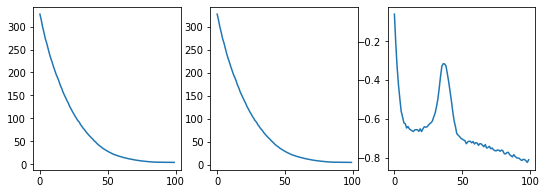

In [451]:
fig, ax = plt.subplots(1,3, figsize = (9,3))
for i in range(3):
    ax[i].plot(loss_mine[:,i])

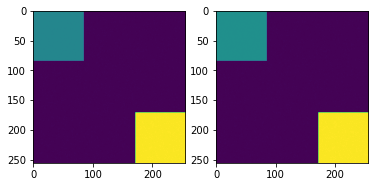

In [452]:
pred = picasso_mine.test(source.float(),sink.float())
pred = pred.reshape(px_size, px_size)
fig, ax = plt.subplots(1,2)
ax[0].imshow(pred)
ax[1].imshow(sink.cpu().reshape(px_size,px_size))

In [433]:
pred

array([[15396.931  , 15347.327  , 15391.5    , ...,   578.3174 ,
          595.76575,   555.1621 ],
       [15431.949  , 15418.793  , 15361.206  , ...,   569.3174 ,
          560.1621 ,   532.7311 ],
       [15419.086  , 15389.638  , 15323.309  , ...,   524.43787,
          623.7832 ,   619.1969 ],
       ...,
       [  543.0242 ,   527.7311 ,   562.17944, ...,  3632.49   ,
         3513.5757 ,  3582.3174 ],
       [  512.5758 ,   553.3174 ,   580.7484 , ...,  3548.8691 ,
         3599.0415 ,  3544.731  ],
       [  579.9037 ,   610.1969 ,   554.88635, ...,  3511.576  ,
         3567.4553 ,  3596.9038 ]], dtype=float32)

In [490]:
_range = range

def histogramdd(sample,bins=None,range=None,weights=None,remove_overflow=True):
    edges=None
    device=None
    custom_edges = False
    D,N = sample.shape
    if device == None:
        device = sample.device
    if bins == None:
        if edges == None:
            bins = 10
            custom_edges = False
        else:
            try:
                bins = edges.size(1)-1
            except AttributeError:
                bins = torch.empty(D)
                for i in _range(len(edges)):
                    bins[i] = edges[i].size(0)-1
                bins = bins.to(device)
            custom_edges = True
    try:
        M = bins.size(0)
        if M != D:
            raise ValueError(
                'The dimension of bins must be equal to the dimension of the '
                ' sample x.')
    except AttributeError:
        # bins is either an integer or a list
        if type(bins) == int:
            bins = torch.full([D],bins,dtype=torch.long,device=device)
        elif torch.is_tensor(bins[0]):
            custom_edges = True
            edges = bins
            bins = torch.empty(D,dtype=torch.long)
            for i in _range(len(edges)):
                bins[i] = edges[i].size(0)-1
            bins = bins.to(device)
        else:
            bins = torch.as_tensor(bins)
    if bins.dim() == 2:
        custom_edges = True
        edges = bins
        bins = torch.full([D],bins.size(1)-1,dtype=torch.long,device=device)
    if custom_edges:
        use_old_edges = False
        if not torch.is_tensor(edges):
            use_old_edges = True
            edges_old = edges
            m = max(i.size(0) for i in edges)
            tmp = torch.empty([D,m],device=edges[0].device)
            for i in _range(D):
                s = edges[i].size(0)
                tmp[i,:]=edges[i][-1]
                tmp[i,:s]=edges[i][:]
            edges = tmp.to(device)
        k = torch.searchsorted(edges,sample)
        k = torch.min(k,(bins+1).reshape(-1,1))
        if use_old_edges:
            edges = edges_old
        else:
            edges = torch.unbind(edges)
    else:
            if range == None: #range is not defined
                range = torch.empty(2,D,device=device)
                if N == 0: #Empty histogram
                    range[0,:] = 0
                    range[1,:] = 1
                else:
                    range[0,:]=torch.min(sample,1)[0]
                    range[1,:]=torch.max(sample,1)[0]
            elif not torch.is_tensor(range): #range is a tuple
                r = torch.empty(2,D)
                for i in _range(D):
                    if range[i] is not None:
                        r[:,i] = torch.as_tensor(range[i])
                    else:
                        if N == 0: #Edge case: empty histogram
                            r[0,i] = 0
                            r[1,i] = 1
                        r[0,i]=torch.min(sample[:,i])[0]
                        r[1,i]=torch.max(sample[:,i])[0]
                range = r.to(device=device,dtype=sample.dtype)
            singular_range = torch.eq(range[0],range[1]) #If the range consists of only one point, pad it up
            range[0,singular_range] -= .5
            range[1,singular_range] += .5
            edges = [torch.linspace(range[0,i],range[1,i],bins[i]+1) for i in _range(len(bins))]
            tranges = torch.empty_like(range)
            tranges[1,:] = bins/(range[1,:]-range[0,:])
            tranges[0,:] = 1-range[0,:]*tranges[1,:]
            k = torch.addcmul(tranges[0,:].reshape(-1,1),sample,tranges[1,:].reshape(-1,1)).long() #Get the right index
            k = torch.max(k,torch.zeros([],device=device,dtype=torch.long)) #Underflow bin
            k = torch.min(k,(bins+1).reshape(-1,1))


    multiindex = torch.ones_like(bins)
    multiindex[1:] = torch.cumprod(torch.flip(bins[1:],[0])+2,-1).long()
    multiindex = torch.flip(multiindex,[0])
    l = torch.sum(k*multiindex.reshape(-1,1),0)
    hist = torch.bincount(l,minlength=(multiindex[0]*(bins[0]+2)).item(),weights=weights)
    hist = hist.reshape(tuple(bins+2))
    if remove_overflow:
        core = D * (slice(1, -1),)
        hist = hist[core]
    return hist,edges

In [495]:
def mutual_information(X, Y, device = None):
    
    X = X.detach(); Y = Y.detach()

    if device is None:
        assert X.device == Y.device
        device = X.device
       
    # compute limits
    xmin = torch.floor(X.min()).long(); xmax = torch.ceil(X.max())
    ymin = torch.floor(Y.min()).long(); ymax = torch.ceil(Y.max())
    # digitize
    X = X.long()-xmin
    Y = Y.long()-ymin
    
    # make bins
    xmax = xmax-xmin+2
    ymax = ymax-ymin+2
    xbins  = torch.arange(0, xmax.short(), device=device).detach()
    ybins  = torch.arange(0, ymax.short(), device=device).detach()
    bins = [xbins, ybins]
    
    # Joint Probability distribution
    H, edge = histogramdd(torch.stack([X, Y], dim=0), bins, remove_overflow=False)
    H = H.detach()/source.size()[0]
    
    # marginal probability distributions
    p_x = H.sum(1)
    p_y = H.sum(0)
    
    # Compute mutual information
    H_ = H[X,Y]
    x_ = p_x[X]
    y_ = p_y[Y]
        
    try:
        MI = torch.mean(torch.log(H_/(x_*y_)))
    except:
        print('H', H.shape)
        print('px', p_x.shape)
        print('py', p_y.shape)
        print('MI failed', xbins, ybins)
        MI = None

    return MI

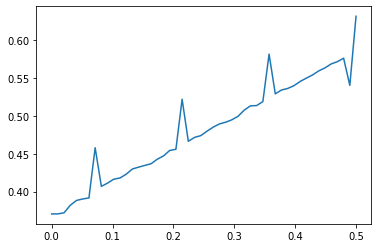

In [509]:
mi = []
alpha = np.linspace(0,0.5,50)
for a in alpha:
    sink_ = sink + a*source
    sink_ = sink_.round().long()
    mi.append(mutual_information(source.float(), sink_.float()).cpu())
    
fig, ax = plt.subplots(1,1)
ax.plot(alpha,mi)

In [508]:
sink_.max()

tensor(3193.5000, device='cuda:0')

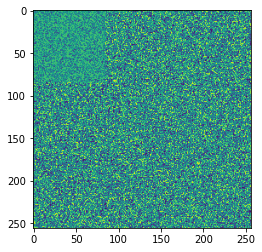

In [24]:
sink_ = sink_.cpu().reshape(256,256)
fig, ax = plt.subplots(1,1)
ax.imshow(sink_)

C:\Users\kpandit\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


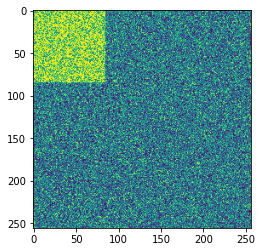

In [68]:
sink_softmax = sink/4095
sink_softmax = torch.nn.functional.softmax(sink_softmax).cpu().reshape(256,256)/4095
fig, ax = plt.subplots(1,1)
ax.imshow(sink_softmax)

tensor([[5.2979e-09, 5.2979e-09, 3.4962e-09,  ..., 3.4186e-09, 4.1979e-09,
         2.4239e-09],
        [5.2979e-09, 5.2979e-09, 3.5800e-09,  ..., 4.8202e-09, 2.4754e-09,
         4.6502e-09],
        [4.9369e-09, 4.3919e-09, 4.4502e-09,  ..., 3.2366e-09, 4.0887e-09,
         3.4169e-09],
        ...,
        [2.4687e-09, 3.0390e-09, 4.0588e-09,  ..., 4.6253e-09, 3.3721e-09,
         2.7914e-09],
        [3.5314e-09, 5.0763e-09, 2.9853e-09,  ..., 4.4383e-09, 3.2771e-09,
         5.0651e-09],
        [4.5747e-09, 4.3407e-09, 4.5915e-09,  ..., 3.9949e-09, 2.9541e-09,
         3.6515e-09]])